,Method,Model,Accuracy,Precision,Recall,F1-score
0,PCA,Random Forest,0.718533,0.720246,0.718533,0.718257
1,PCA,Gradient Boosting,0.713578,0.714419,0.713578,0.713487
2,PCA,SVM,0.727453,0.730847,0.727453,0.726811
3,PCA,AdaBoost,0.675917,0.676348,0.675917,0.675893
4,PCA,KNN,0.666997,0.671173,0.666997,0.665650
5,PCA,Naïve Bayes,0.621407,0.651800,0.621407,0.604256
6,PCA,ANN (MLPClassifier),0.724480,0.724649,0.724480,0.724493
7,PCA,Decision Tree,0.652131,0.653684,0.652131,0.651719
8,Correlation (0.9),Random Forest,0.774034,0.776223,0.774034,0.773782
9,Correlation (0.9),Gradient Boosting,0.795837,0.796231,0.795837,0.795834


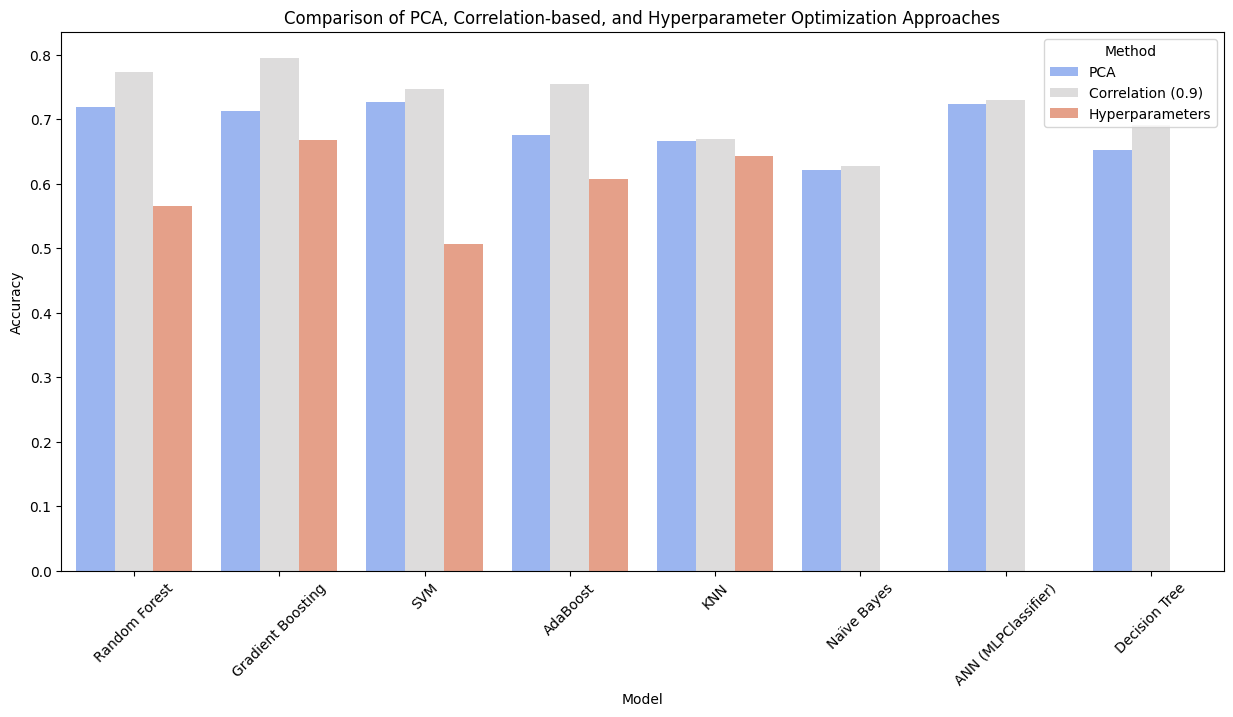

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Dataset
df = pd.read_csv('movie_metadata.csv')

def preprocess_data(df, apply_pca=False, correlation_threshold=None):
    df.drop(columns=['movie_title', 'movie_imdb_link', 'plot_keywords'], inplace=True, errors="ignore")
    df.fillna(df.median(numeric_only=True), inplace=True)
    df["success"] = df["imdb_score"].apply(lambda x: "Good" if x > 6.5 else "Bad")
    
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    df["success"] = LabelEncoder().fit_transform(df["success"])
    
    X = df.drop(columns=["imdb_score", "success"], errors="ignore")
    y = df["success"]
    
    if correlation_threshold is not None:
        correlation_matrix = X.corr()
        high_corr_features = set()
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                    high_corr_features.add(correlation_matrix.columns[i])
        X.drop(columns=high_corr_features, inplace=True, errors="ignore")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if apply_pca:
        pca = PCA(n_components=0.95)
        X_scaled = pca.fit_transform(X_scaled)
    
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

def evaluate_models(X_train, X_test, y_train, y_test, method_name, models):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append([method_name, name, acc, precision, recall, f1])
    return results

# Model sets
models_default = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, subsample=0.8),
    "SVM": SVC(C=10, kernel='rbf', gamma='scale', probability=True),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=1.0),
    "KNN": KNeighborsClassifier(n_neighbors=9, weights='distance', metric='minkowski'),
    "Naïve Bayes": GaussianNB(var_smoothing=1e-9),
    "ANN (MLPClassifier)": MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', alpha=0.0001, max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=2, criterion='gini')
}

models_tuned = {
    "Random Forest": RandomForestClassifier(n_estimators=1, max_depth=1, min_samples_split=3, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=19, learning_rate=0.001, max_depth=10),
    "SVM": SVC(C=0.001, kernel='rbf'),
    "AdaBoost": AdaBoostClassifier(n_estimators=1, learning_rate=1),
    "KNN": KNeighborsClassifier(n_neighbors=1, weights='uniform')
}

results_all = []

# PCA-based approach
X_train, X_test, y_train, y_test = preprocess_data(df.copy(), apply_pca=True)
results_all.extend(evaluate_models(X_train, X_test, y_train, y_test, "PCA", models_default))

# Correlation-based approach (Threshold = 0.9)
X_train, X_test, y_train, y_test = preprocess_data(df.copy(), correlation_threshold=0.9)
results_all.extend(evaluate_models(X_train, X_test, y_train, y_test, "Correlation (0.9)", models_default))

# Hyperparameter tuning
X_train, X_test, y_train, y_test = preprocess_data(df.copy())
results_all.extend(evaluate_models(X_train, X_test, y_train, y_test, "Hyperparameters", models_tuned))

# Convert results to DataFrame
df_results = pd.DataFrame(results_all, columns=["Method", "Model", "Accuracy", "Precision", "Recall", "F1-score"])
display(df_results)

# Plot results
plt.figure(figsize=(15, 7))
sns.barplot(data=df_results, x="Model", y="Accuracy", hue="Method", palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of PCA, Correlation-based, and Hyperparameter Optimization Approaches")
plt.xticks(rotation=45)
plt.legend(title="Method")
plt.show()